In [2]:
%matplotlib inline

## Transforms and registration

### swirl
- non-linear image deformation = whirlpool effect.
- uses _reverse mapping_ during a transformation to ensure 1:1 px matching

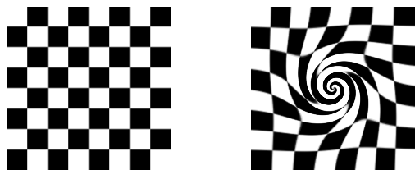

In [3]:
import matplotlib.pyplot as plt
from skimage           import data
from skimage.transform import swirl

def shift_left(xy):
    xy[:, 0] += 50
    return xy

image = data.checkerboard()
swirled = swirl(image, rotation=0, strength=10, radius=120)

# ----------------------------------------------------------------
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3),
                               sharex=True, sharey=True)

ax0.imshow(image, cmap=plt.cm.gray)
ax0.axis('off')
ax1.imshow(swirled, cmap=plt.cm.gray)
ax1.axis('off')
plt.show()

### image pyramids
- _pyramid_gaussian_ returns successive images shrunk by constant scale.
- used for denoising, texture discrimination, scale-invariant detection.

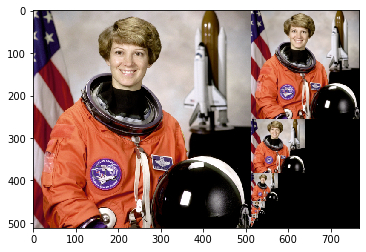

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage           import data
from skimage.transform import pyramid_gaussian

image           = data.astronaut()
rows, cols, dim = image.shape
pyramid         = tuple(pyramid_gaussian(image, 
                                         downscale=2, 
                                         multichannel=True))

composite_image = np.zeros((rows, 
                            cols + cols//2, 3), dtype=np.double)

composite_image[:rows, :cols, :] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols                                            = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row                                                    += n_rows

# ---------------------------------------------------------------------
fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

### interpolation: edge modes
- used by _skimage.transform.rescale()_, _skimage.transform.resize()_
- modes: constant, edge, wrap, reflect, symmetric

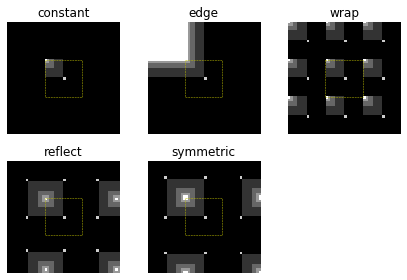

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import pad

img = np.zeros((16, 16))
img[:8, :8] += 1
img[:4, :4] += 1
img[:2, :2] += 1
img[:1, :1] += 2
img[8, 8] = 4

modes     = ['constant', 'edge', 'wrap', 'reflect', 'symmetric']
fig, axes = plt.subplots(2, 3)
ax        = axes.flatten()

# -------------------------------------------------------------------
for n, mode in enumerate(modes):
    img_padded = pad(img, pad_width=img.shape[0], mode=mode)
    ax[n].imshow(img_padded, cmap=plt.cm.gray)
    ax[n].plot([15.5, 15.5, 31.5, 31.5, 15.5],
               [15.5, 31.5, 31.5, 15.5, 15.5], 'y--', linewidth=0.5)
    ax[n].set_title(mode)

for a in ax:
    a.set_axis_off()
    a.set_aspect('equal')

plt.tight_layout()
plt.show()


### rescale, resize, downscale
- _rescale_: resizes image by given scalars (single value or one per axis)
- _resize_: specifies output shape instead of scaler
- _downscale_: down-samples n-dim image using local mean on element blocks

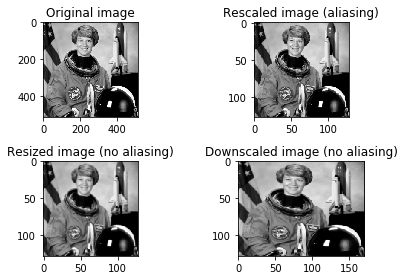

In [6]:
import matplotlib.pyplot as plt
from skimage           import data, color
from skimage.transform import rescale, resize, downscale_local_mean

image            = color.rgb2gray(data.astronaut())
image_rescaled   = rescale(image, 0.25, anti_aliasing=False)
image_resized    = resize(image, (image.shape[0]//4, 
                                  image.shape[1]//4),
                                  anti_aliasing=True)
image_downscaled = downscale_local_mean(image, 
                                        (4, 3))

# ------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2)
ax = axes.ravel()

ax[0].imshow(image,            cmap='gray')
ax[1].imshow(image_rescaled,   cmap='gray')
ax[2].imshow(image_resized,    cmap='gray')
ax[3].imshow(image_downscaled, cmap='gray')

ax[0].set_title("Original image")
ax[1].set_title("Rescaled image (aliasing)")
ax[2].set_title("Resized image (no aliasing)")
ax[3].set_title("Downscaled image (no aliasing)")

ax[0].set_xlim(0, 512)
ax[0].set_ylim(512, 0)
plt.tight_layout()
plt.show()


### piecewise affine transformation

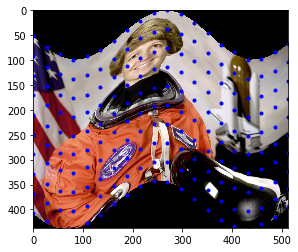

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
from skimage           import data

image              = data.astronaut()
rows, cols         = image.shape[0], image.shape[1]
src_cols           = np.linspace(0, cols, 20)
src_rows           = np.linspace(0, rows, 10)
src_rows, src_cols = np.meshgrid(src_rows, src_cols)
src                = np.dstack([
    src_cols.flat, 
    src_rows.flat])[0]

# add sinusoidal oscillation to row coordinates
dst_rows  = src[:, 1] - np.sin(np.linspace(0, 3*np.pi, src.shape[0])) * 50
dst_cols  = src[:, 0]
dst_rows *= 1.5
dst_rows -= 1.5 * 50
dst       = np.vstack([dst_cols, dst_rows]).T

tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

out_rows = image.shape[0] - 1.5 * 50
out_cols = cols
out      = warp(image, tform, output_shape=(out_rows, out_cols))

# --------------------------------------------------------------
fig, ax  = plt.subplots()
ax.imshow(out)
ax.plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.b')
ax.axis((0, out_cols, out_rows, 0))
plt.show()


### structural similarity index
- MSE (mean sq error) is not good measure of image similarity.
- structural similar accounts of textures
- below: two mods of image with same MSE, but different struct similarities.

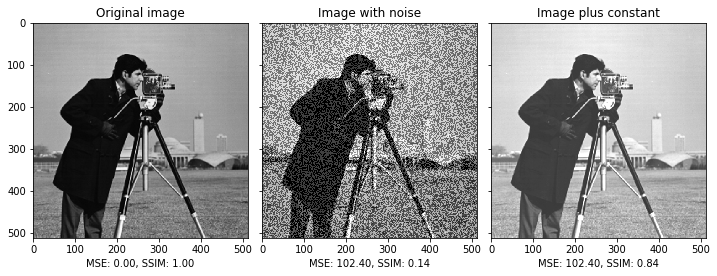

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage         import data, img_as_float
from skimage.metrics import structural_similarity as ssim

img        = img_as_float(data.camera())
rows, cols = img.shape
noise      = np.ones_like(img) * 0.2 * (img.max() - img.min())

noise[np.random.random(size=noise.shape) > 0.5] *= -1

def mse(x, y):
    return np.linalg.norm(x - y)

img_noise = img + noise
img_const = img + abs(noise)

# -----------------------------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mse(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())

mse_noise = mse(img, img_noise)
ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min())

mse_const = mse(img, img_const)
ssim_const = ssim(img, img_const,
                  data_range=img_const.max() - img_const.min())

label = 'MSE: {:.2f}, SSIM: {:.2f}'

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(label.format(mse_none, ssim_none))
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(label.format(mse_noise, ssim_noise))
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(label.format(mse_const, ssim_const))
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()


### cross-correlation (phase correlation)
- below: use PC to find relative shift btwn 2 similar-sized images
- _register_translation_ uses cross-correlation in Fourier space

Known offset (y, x): (-22.4, 13.32)


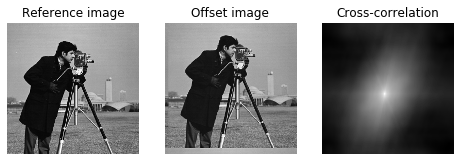

Detected pixel offset (y, x): [ 22. -13.]


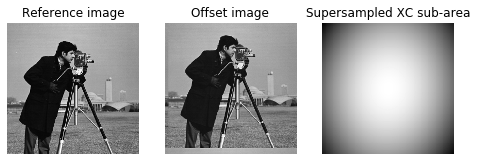

Detected subpixel offset (y, x): [ 22.4  -13.32]


In [11]:
import numpy as np
import matplotlib.pyplot as plt

from skimage                              import data
from skimage.feature                      import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage                        import fourier_shift

# The shift corresponds to the pixel offset relative to the reference image

image        = data.camera()
shift        = (-22.4, 13.32)
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)

print(f"Known offset (y, x): {shift}")

# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)
# -----------------------------------------------------------------
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f"Detected pixel offset (y, x): {shift}")

# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, 100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f"Detected subpixel offset (y, x): {shift}")


### fundamental matrix (FM) estimation
- how to estimate epipolar geometry btwn 2 views using sparse ORB correspondences
- FM relates corresponding points btwn pair of uncalibrated images
- "uncalibrated": intrinsic camera calibration params are not known.
- FM thus enables projective 3D reconstruction of a captured scene.

Number of matches: 223
Number of inliers: 164


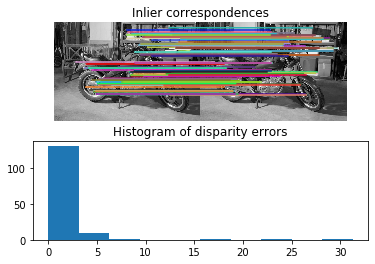

In [10]:
import numpy as np
from skimage           import data
from skimage.color     import rgb2gray
from skimage.feature   import match_descriptors, ORB, plot_matches
from skimage.measure   import ransac
from skimage.transform import FundamentalMatrixTransform
import matplotlib.pyplot as plt

np.random.seed(0)

img_left, img_right, groundtruth_disp = data.stereo_motorcycle()
img_left, img_right = map(rgb2gray, (img_left, img_right))

# Find sparse feature correspondences between left and right image.

descriptor_extractor = ORB()

descriptor_extractor.detect_and_extract(img_left)
keypoints_left    = descriptor_extractor.keypoints
descriptors_left  = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img_right)
keypoints_right   = descriptor_extractor.keypoints
descriptors_right = descriptor_extractor.descriptors

matches = match_descriptors(descriptors_left, 
                            descriptors_right,
                            cross_check=True)

# Estimate the epipolar geometry between the left and right image.

model, inliers = ransac((keypoints_left[matches[:, 0]],
                         keypoints_right[matches[:, 1]]),
                        FundamentalMatrixTransform, 
                        min_samples=8,
                        residual_threshold=1, 
                        max_trials=5000)

inlier_keypoints_left  = keypoints_left[matches[inliers, 0]]
inlier_keypoints_right = keypoints_right[matches[inliers, 1]]

print(f"Number of matches: {matches.shape[0]}")
print(f"Number of inliers: {inliers.sum()}")

# Compare estimated sparse disparities to the dense ground-truth disparities.

disp        = inlier_keypoints_left[:, 1] - inlier_keypoints_right[:, 1]
disp_coords = np.round(inlier_keypoints_left).astype(np.int64)
disp_idxs   = np.ravel_multi_index(disp_coords.T, groundtruth_disp.shape)
disp_error  = np.abs(groundtruth_disp.ravel()[disp_idxs] - disp)
disp_error  = disp_error[np.isfinite(disp_error)]

# --------------------------------------------------------------------
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

plot_matches(ax[0], img_left, img_right, keypoints_left, keypoints_right,
             matches[inliers], only_matches=True)
ax[0].axis("off")
ax[0].set_title("Inlier correspondences")

ax[1].hist(disp_error)
ax[1].set_title("Histogram of disparity errors")

plt.show()

### masked normalized cross-correlation
- used to ID relative shift btwn 2 images containing invalid data
- in this case: images can't be masked - masks will influence the math.
- below: register the image translation; one img has ~25% corrupt px.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from skimage         import data, draw
from skimage.feature import masked_register_translation
from scipy           import ndimage as ndi

Known offset (row, col): (-22, 13)
Detected pixel offset (row, col): [-22.  13.]


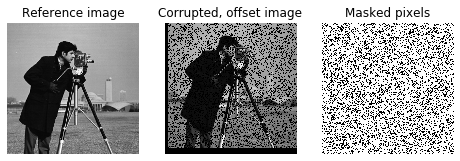

In [13]:
image = data.camera()
shift = (-22, 13)

corrupted_pixels = np.random.choice([False, True],
                                    size = image.shape,
                                    p = [0.25, 0.75])

# The shift corresponds to the pixel offset relative to the reference image
offset_image = ndi.shift(image, shift)
offset_image *= corrupted_pixels
print(f"Known offset (row, col): {shift}")

# Determine what the mask is based on which pixels are invalid
# In this case, we know what the mask should be since we corrupted
# the pixels ourselves
mask = corrupted_pixels

detected_shift = masked_register_translation(image, offset_image, mask)

print(f"Detected pixel offset (row, col): {-detected_shift}")

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3, sharex=ax1, sharey=ax1)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Corrupted, offset image')

ax3.imshow(mask, cmap='gray')
ax3.set_axis_off()
ax3.set_title('Masked pixels')

plt.show()

- solid masks = another example.
- _masked_register_translation_ will ID which part of images should be compared.

Known offset (row, col): (-22, 13)
Detected pixel offset (row, col): [-22.  13.]


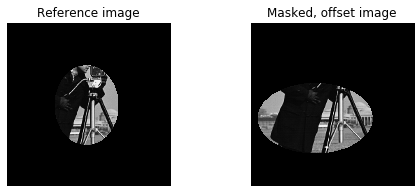

In [14]:
image    = data.camera()
shift    = (-22, 13)
rr1, cc1 = draw.ellipse(259, 248, 
                        r_radius = 125, 
                        c_radius = 100, 
                        shape = image.shape)
rr2, cc2 = draw.ellipse(300, 200,
                        r_radius = 110, 
                        c_radius = 180,
                        shape = image.shape)

mask1           = np.zeros_like(image, dtype = np.bool)
mask2           = np.zeros_like(image, dtype = np.bool)
mask1[rr1, cc1] = True
mask2[rr2, cc2] = True
offset_image    = ndi.shift(image, shift)
image          *= mask1
offset_image   *= mask2

print(f"Known offset (row, col): {shift}")

detected_shift = masked_register_translation(
    image, 
    offset_image, 
    mask1, mask2)

print(f"Detected pixel offset (row, col): {-detected_shift}")

# ------------------------------------------------------------
fig = plt.figure(figsize=(8,3))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Masked, offset image')

plt.show()

### polar, log-polar transforms
- rotation diffs btwn 2 images can be converted to translation diffs along angular coordinate axis of polar-transformed images.
- below: use phase correlation to recover rotation and scaling diffs btwn 2 images that share a center point.

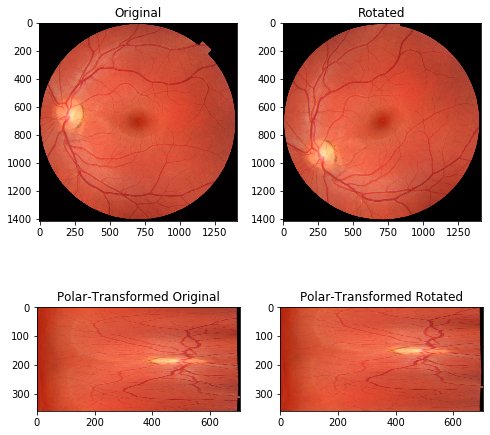

Expected value for counterclockwise rotation in degrees: 35
Recovered value for counterclockwise rotation: 35.0


In [15]:
import numpy as np
import matplotlib.pyplot as plt

from skimage           import data
from skimage.feature   import register_translation
from skimage.transform import warp_polar, rotate
from skimage.util      import img_as_float

radius, angle = 705, 35
image         = data.retina()
image         = img_as_float(image)
rotated       = rotate(image, angle)
image_polar   = warp_polar(image,   radius=radius, multichannel=True)
rotated_polar = warp_polar(rotated, radius=radius, multichannel=True)

# ---------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original")
ax[0].imshow(image)
ax[1].set_title("Rotated")
ax[1].imshow(rotated)
ax[2].set_title("Polar-Transformed Original")
ax[2].imshow(image_polar)
ax[3].set_title("Polar-Transformed Rotated")
ax[3].imshow(rotated_polar)
plt.show()

shifts, error, phasediff = register_translation(image_polar, rotated_polar)
print("Expected value for counterclockwise rotation in degrees: "
      f"{angle}")
print("Recovered value for counterclockwise rotation: "
      f"{shifts[0]}")


#### recovering rotation & scale diffs with log-polar transforms

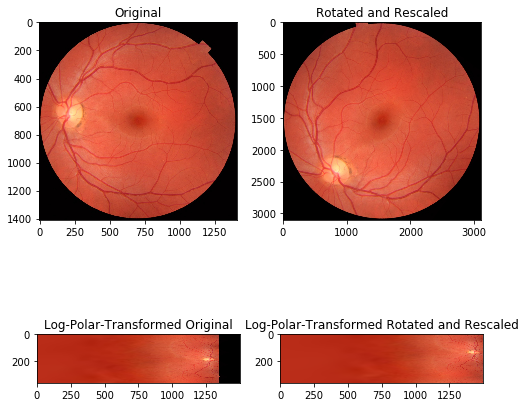

Expected value for cc rotation in degrees: 53.7
Recovered value for cc rotation: 53.75

Expected value for scaling difference: 2.2
Recovered value for scaling difference: 2.1981889915232165


In [16]:
from skimage.transform import rescale

# radius must be large enough to capture useful info in larger image
radius, angle  = 1500, 53.7
scale          = 2.2
image          = data.retina()
image          = img_as_float(image)
rotated        = rotate(image, angle)
rescaled       = rescale(rotated, scale, multichannel=True)
image_polar    = warp_polar(image, 
                            radius=radius,
                            scaling='log', 
                            multichannel=True)
rescaled_polar = warp_polar(rescaled, 
                            radius=radius,
                            scaling='log', 
                            multichannel=True)

# ----------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original")
ax[0].imshow(image)
ax[1].set_title("Rotated and Rescaled")
ax[1].imshow(rescaled)
ax[2].set_title("Log-Polar-Transformed Original")
ax[2].imshow(image_polar)
ax[3].set_title("Log-Polar-Transformed Rotated and Rescaled")
ax[3].imshow(rescaled_polar)
plt.show()

# setting `upsample_factor` can increase precision
tparams = register_translation(image_polar, rescaled_polar, upsample_factor=20)
shifts, error, phasediff = tparams
shiftr, shiftc = shifts[:2]

# Calculate scale factor from translation
klog = radius / np.log(radius)
shift_scale = 1 / (np.exp(shiftc / klog))

print(f"Expected value for cc rotation in degrees: {angle}")
print(f"Recovered value for cc rotation: {shiftr}")
print()
print(f"Expected value for scaling difference: {scale}")
print(f"Recovered value for scaling difference: {shift_scale}")

### robust line model estimation with RANSAC
- below: gaussian noise added to linear function, + outlier points added.

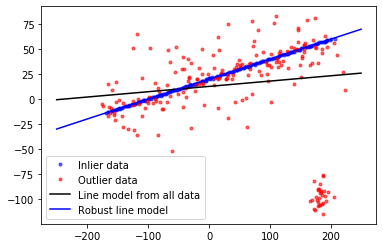

In [17]:
import numpy as np
from matplotlib import pyplot as plt

from skimage.measure import LineModelND, ransac


np.random.seed(seed=1)

# generate coordinates of line
x    = np.arange(-200, 200)
y    = 0.2 * x + 20
data = np.column_stack([x, y])

# add gaussian noise to coordinates
noise      = np.random.normal(size=data.shape)
data      += 0.5 * noise
data[::2] += 5   * noise[::2]
data[::4] += 20  * noise[::4]

# add faulty data
faulty                 = np.array(30 * [(180., -100)])
faulty                += 10 * np.random.normal(size=faulty.shape)
data[:faulty.shape[0]] = faulty

# fit line using all data
model = LineModelND()
model.estimate(data)

# robustly fit line only using inlier data with RANSAC algorithm
model_robust, inliers = ransac(data, 
                               LineModelND, 
                               min_samples=2,
                               residual_threshold=1, 
                               max_trials=1000)
outliers = inliers == False

# generate coordinates of estimated models
line_x        = np.arange(-250, 250)
line_y        = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)

# ------------------------------------------------------------------
fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6,
        label='Inlier data')
ax.plot(data[outliers, 0], data[outliers, 1], '.r', alpha=0.6,
        label='Outlier data')
ax.plot(line_x, line_y, '-k', label='Line model from all data')
ax.plot(line_x, line_y_robust, '-b', label='Robust line model')
ax.legend(loc='lower left')
plt.show()


### radon transform
- use case: tomography
- get tomographic slice image from a set of projections
- projection formed by drawing set of parallel beams thru 2D object
- assign integral of object's contrast along each beam to a single px.
- projections from multiple angles (a "sinogram") needed to enable reconstruction.
- inverse radon transform: reconstructs object from sinogram
- forward radon transform: simulates a tomography experiment.
- below: comparison of two methods:
    - filtered back projection (FBP)
    - simultaneous algebraic reconstruction technique (SART)

#### forward transform
- use Shepp-Logan phantom as original image
- how many projection angles needed? (start with ~ #px across the object)

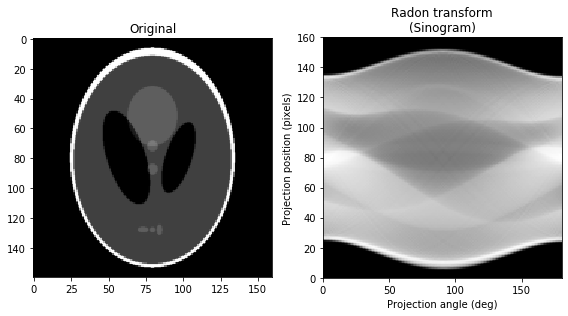

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io        import imread
from skimage.data      import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, 
                scale=0.4, 
                mode='reflect', 
                multichannel=False)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, 
                 theta=theta, 
                 circle=True)

# -------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()


#### reconstruction with filtered back projection (FBP)
- math foundation: Fourier slice theorem. (look it up.)

FBP rms reconstruction error: 0.0283


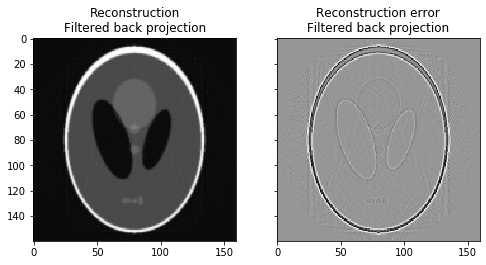

In [19]:
from skimage.transform import iradon

reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error              = reconstruction_fbp - image

print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

imkwargs = dict(vmin=-0.2, vmax=0.2)

# -----------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(8, 4.5),
                               sharex=True, sharey=True)

ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()


#### algebraic reconstruction

SART (1 iteration) rms reconstruction error: 0.0329
SART (2 iterations) rms reconstruction error: 0.0214


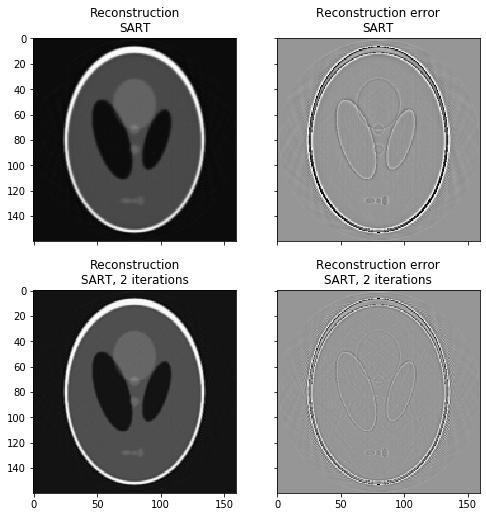

In [20]:
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta)
error               = reconstruction_sart - image

print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

# -----------------------------------------------------------

fig, axes = plt.subplots(2, 2, 
                         figsize=(8, 8.5), 
                         sharex=True, sharey=True)
ax = axes.ravel()
ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)
ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r, **imkwargs)

# Run 2nd iteration of SART:
# supply reconstruction from 1st iteration as initial estimate
reconstruction_sart2 = iradon_sart(sinogram, 
                                   theta=theta,
                                   image=reconstruction_sart)

error = reconstruction_sart2 - image
print("SART (2 iterations) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

# -----------------------------------------------------------

ax[2].set_title("Reconstruction\nSART, 2 iterations")
ax[2].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART, 2 iterations")
ax[3].imshow(reconstruction_sart2 - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()


### robust matching with RANSAC
- 1) generate two synthetic images as if they were taken from diff viewpoints.
- 2) find interest points in both images, find correspondences
- end with sets of source & destination coordinates, which can be used to estimate geometric transformations.
- however, many correspondences will be faulty. use RANSAC on top of normal model to detect outliers and estimate the parameter set.

Ground truth:
Scale: (0.9000, 0.9000), Translation: (-10.0000, 20.0000), Rotation: -0.2000
Affine transform:
Scale: (0.9015, 0.8913), Translation: (-9.3136, 14.9768), Rotation: -0.1678
RANSAC:
Scale: (0.8999, 0.9001), Translation: (-10.0005, 19.9744), Rotation: -0.1999


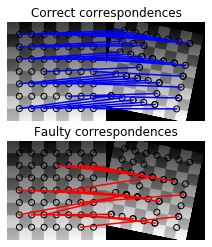

In [21]:
import numpy as np
from matplotlib import pyplot as plt

from skimage           import data
from skimage.util      import img_as_float
from skimage.feature   import (corner_harris, 
                               corner_subpix, 
                               corner_peaks,
                               plot_matches)
from skimage.transform import warp, AffineTransform
from skimage.exposure  import rescale_intensity
from skimage.color     import rgb2gray
from skimage.measure   import ransac


# generate synthetic checkerboard - add gradient for the later matching
checkerboard           = img_as_float(data.checkerboard())
img_orig               = np.zeros(list(checkerboard.shape) + [3])
img_orig[..., 0]       = checkerboard
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1]       = gradient_r
img_orig[..., 2]       = gradient_c
img_orig               = rescale_intensity(img_orig)
img_orig_gray          = rgb2gray(img_orig)

# warp synthetic image
tform                  = AffineTransform(scale=(0.9, 0.9), 
                                         rotation=0.2, 
                                         translation=(20, -10))
img_warped             = warp(img_orig, 
                              tform.inverse, 
                              output_shape=(200, 200))
img_warped_gray        = rgb2gray(img_warped)

# extract corners using Harris' corner measure
coords_orig            = corner_peaks(corner_harris(img_orig_gray), 
                                      threshold_rel=0.001,
                                      min_distance=5)
coords_warped          = corner_peaks(corner_harris(img_warped_gray),
                                      threshold_rel=0.001, 
                                      min_distance=5)

# determine sub-pixel corner position
coords_orig_subpix     = corner_subpix(img_orig_gray, 
                                       coords_orig, 
                                       window_size=9)
coords_warped_subpix   = corner_subpix(img_warped_gray, 
                                       coords_warped,
                                       window_size=9)

def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g    = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g   /= 2*np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c        = np.round(coord).astype(np.intp)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)

# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), 
                               AffineTransform, 
                               min_samples=3,
                               residual_threshold=2, 
                               max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
print("Ground truth:")
print(f"Scale: ({tform.scale[1]:.4f}, {tform.scale[0]:.4f}), "
      f"Translation: ({tform.translation[1]:.4f}, "
      f"{tform.translation[0]:.4f}), "
      f"Rotation: {-tform.rotation:.4f}")
print("Affine transform:")
print(f"Scale: ({model.scale[0]:.4f}, {model.scale[1]:.4f}), "
      f"Translation: ({model.translation[0]:.4f}, "
      f"{model.translation[1]:.4f}), "
      f"Rotation: {model.rotation:.4f}")
print("RANSAC:")
print(f"Scale: ({model_robust.scale[0]:.4f}, {model_robust.scale[1]:.4f}), "
      f"Translation: ({model_robust.translation[0]:.4f}, "
      f"{model_robust.translation[1]:.4f}), "
      f"Rotation: {model_robust.rotation:.4f}")

# --------------------------------------------------------------------
fig, ax = plt.subplots(nrows=2, ncols=1)
plt.gray()
inlier_idxs = np.nonzero(inliers)[0]

plot_matches(ax[0], 
             img_orig_gray, 
             img_warped_gray, 
             src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), 
             matches_color='b')

ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], 
             img_orig_gray, 
             img_warped_gray, 
             src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), 
             matches_color='r')

ax[1].axis('off')
ax[1].set_title('Faulty correspondences')
plt.show()